# 1. Project Overview
Zone Classification for Bilbao Housing Listings
This notebook builds a multi-class classifier to predict the zone of a property in Bilbao using structured listing features.
Pipeline Outline:
1. Data loading & basic preprocessing (drop non-predictive text, cast object -> categorical).
2. Target definition: predict broader zone (remove neighborhood for generalization).
3. Multiple modeling strategies (encoded vs native categorical handling, SVM dimensionality reduction, class weighting).
4. Rich evaluation metrics emphasizing macro F1 and Matthews correlation for imbalanced classes.
5. Progressive hyperparameter tuning: wide RandomizedSearch, refined RandomizedSearch, Optuna optimization.
6. Feature engineering: create price_per_m2 feature to improve separability.
7. Final champion LightGBM model retrained with optimized parameters + engineered feature.
8. Interpretability: feature importance ranking, confusion matrix, minority class error analysis.
9. Model persistence (joblib dump).

## 2. Imports

In [1]:
# Core imports
import pandas as pd
import numpy as np
import re

# Model imports (baseline + advanced)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing & evaluation imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold

## 3. Data Loading & Basic Preprocessing

In [2]:
data = pd.read_csv('../data/cleaned/data_final.csv')

# Drop non-predictive free-text columns
data = data.drop(columns=["url", "description"])

# Cast object/text columns to categorical dtype for algorithms that support native categorical handling
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# Optional inspection
# data.info()
# data.head()

## 4. Problem Definition: Zone Classification
We aim to predict the broader `zone` category for each property listing. The more granular `neighborhood` column is removed to focus on generalized zone placement.

### 5. Feature / Target Separation

In [3]:
# Remove neighborhood to classify broader zone
data_zone = data.drop(columns=["neighborhood"])

# Split predictors and target
X_zone = data_zone.drop(columns=["zone"])
y_zone = data_zone["zone"]

# Optional sanity checks
# print(y_zone.head())
# X_zone.head()

### 6. Evaluation Setup: Metrics & Model Zoo

In [4]:
# Multi-metric scoring for imbalance & multi-class quality
SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',        # Critical: reveals performance on minority classes
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

# Diverse baseline and advanced models
MODELS = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),  # commented due to runtime cost
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

# Stratified CV preserves class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Train/Test Split
We do the `train_test_split` at the beginning to avoid data leakage. We will use `X_train` y `y_train` for cross validation and Optuna; the final performance will be measured using `X_test` and `y_test`.

In [5]:
# Train/Test Split – evitar data leakage
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

# Asumimos que `X_zone` y `y_zone` ya están construidos en las celdas previas
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_zone, y_zone,
    test_size=0.2,
    stratify=y_zone,
    random_state=RANDOM_STATE
)

### 7. Model Evaluation Helper

In [6]:
def evaluate_models(X, y, cv_strategy=cv_strategy, scoring=SCORING, models=MODELS):
    """Cross-validate a dictionary of models, returning mean/std for each metric."""
    results = {}
    for name, model in models.items():
        print(f"\n{name}:")
        scores = cross_validate(model, X, y, cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
        results[name] = {}
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                results[name][metric] = (metric_scores.mean(), metric_scores.std())
                print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")
    return results

### 8. Strategy 1: One-Hot Encode Selected Categoricals

In [7]:
# Strategy 1
print("="*80)
print("Strategy 1: Use all variables; one-hot encode selected categorical features")
print("="*80)

cat_cols1 = ["exterior", "condition", "agency", "consumption_label", "emissions_label"]

X_zone_encoded_1 = pd.get_dummies(X_train_raw, columns=cat_cols1)
# Remove special characters from column names to avoid issues in certain models
X_zone_encoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_1.columns]
y_zone_encoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result1 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1: Use all variables; one-hot encode selected categorical features

Samples: 983
Features: 324
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

Random Forest:
  accuracy: 0.5941 (+/- 0.0111)
  recall_weighted: 0.5941 (+/- 0.0111)
  precision_weighted: 0.6260 (+/- 0.0213)
  f1_weighted: 0.5797 (+/- 0.0118)
  f1_macro: 0.5569 (+/- 0.0323)
  matthews: 0.5398 (+/- 0.0130)
  balanced_accuracy: 0.5334 (+/- 0.0280)

Random Forest (tuned):
  accuracy: 0.5321 (+/- 0.0213)
  recall_weighted: 0.5321 (+/- 0.0213)
  precision_weighted: 0.5999 (+/- 0.0626)
  f1_weighted: 0.5012 (+/- 0.0219)
  f1_macro: 0.4516 (+/- 0.0424)
  matthews: 0.4697 (+/- 0.0254)
  balanced_accuracy: 0.4320 (+/- 0.0332)

Logistic Regression:
  accuracy: 0.2971 (+/- 0.0222)
  recall_weighted: 0.2971 (+/- 0.0222)
  precision_weighted: 0.1864 (+/- 0.0403)
  f1_weighted: 0.1955 (+/- 0.0114)
  f1_macro: 0.1164 (+/- 0.0083)
  matthews: 0.1875 (+/- 0.0293)
  balanced_accuracy: 0.1754 (+/- 0.0126)

Naive Ba

### 9. Strategy 1.1: Native Categorical Handling

In [8]:
# Models that natively handle categorical features
MODELS_NATIVE = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1,
        tree_method="hist", enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False,
        cat_features=cat_cols1),
}

print("="*80)
print("Strategy 1.1: Use all variables with native categorical support (no one-hot)")
print("="*80)

X_zone_unencoded_1 = X_train_raw.copy()
# Clean column names (avoid special chars)
X_zone_unencoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_unencoded_1.columns]
y_zone_unencoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_unencoded_1)}")
print(f"Features: {X_zone_unencoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_unencoded_1)}")

result11 = evaluate_models(X_zone_unencoded_1, y_zone_unencoded_1, models=MODELS_NATIVE, scoring=SCORING)
print("\n" + "="*80)

Strategy 1.1: Use all variables with native categorical support (no one-hot)

Samples: 983
Features: 17
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

XGBoost:
  accuracy: 0.5911 (+/- 0.0214)
  recall_weighted: 0.5911 (+/- 0.0214)
  precision_weighted: 0.5983 (+/- 0.0155)
  f1_weighted: 0.5851 (+/- 0.0228)
  f1_macro: 0.5840 (+/- 0.0311)
  matthews: 0.5368 (+/- 0.0236)
  balanced_accuracy: 0.5753 (+/- 0.0348)

LightGBM:
  accuracy: 0.6297 (+/- 0.0216)
  recall_weighted: 0.6297 (+/- 0.0216)
  precision_weighted: 0.6384 (+/- 0.0263)
  f1_weighted: 0.6212 (+/- 0.0222)
  f1_macro: 0.5996 (+/- 0.0137)
  matthews: 0.5805 (+/- 0.0248)
  balanced_accuracy: 0.5914 (+/- 0.0155)

CatBoost:
  accuracy: 0.5503 (+/- 0.0143)
  recall_weighted: 0.5503 (+/- 0.0143)
  precision_weighted: 0.5654 (+/- 0.0227)
  f1_weighted: 0.5386 (+/- 0.0155)
  f1_macro: 0.5104 (+/- 0.0170)
  matthews: 0.4895 (+/- 0.0162)
  balanced_accuracy: 0.4973 (+/- 0.0168)



### 10. Strategy 1.2: SVM with Reduced Dimensionality

In [9]:
'''
# SVM models (runtime heavy; dimensionality reduced by dropping high-cardinality/less informative categorical columns)
MODELS_SVM = {
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True)
}

print("="*80)
print("Strategy 1.2: SVM with reduced categorical set (agency & energy labels removed)")
print("="*80)

X_zone_encoded_12 = X_train_raw.copy()
X_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)

cat_cols12 = ["exterior", "condition"]
X_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)
X_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]

y_zone_encoded_12 = LabelEncoder().fit_transform(y_train_raw)
print(f"\nSamples: {len(X_zone_encoded_12)}")
print(f"Features: {X_zone_encoded_12.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_12)}")

result12 = evaluate_models(X_zone_encoded_12, y_zone_encoded_12, models=MODELS_SVM, scoring=SCORING)

print("\n" + "="*80)
'''

'\n# SVM models (runtime heavy; dimensionality reduced by dropping high-cardinality/less informative categorical columns)\nMODELS_SVM = {\n    \'SVM (Linear)\': SVC(kernel=\'linear\', random_state=42, probability=True),\n    \'SVM (RBF)\': SVC(kernel=\'rbf\', random_state=42, probability=True)\n}\n\nprint("="*80)\nprint("Strategy 1.2: SVM with reduced categorical set (agency & energy labels removed)")\nprint("="*80)\n\nX_zone_encoded_12 = X_train_raw.copy()\nX_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)\n\ncat_cols12 = ["exterior", "condition"]\nX_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)\nX_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]\n\ny_zone_encoded_12 = LabelEncoder().fit_transform(y_train_raw)\nprint(f"\nSamples: {len(X_zone_encoded_12)}")\nprint(f"Features: {X_zone_encoded_12.shape[1]}")\nprint(f"Class distribution: {np.bincount(y_

### 11. Strategy 1.3: Class Weight Balancing

In [10]:
# Test multiple models with class_weight adjustments where supported
MODELS_BALANCED = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight='balanced'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

print("="*80)
print("Strategy 1.3: Evaluate models with class_weight='balanced'")
print("="*80)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result13 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS_BALANCED, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1.3: Evaluate models with class_weight='balanced'

Samples: 983
Features: 324
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

Random Forest:
  accuracy: 0.5697 (+/- 0.0244)
  recall_weighted: 0.5697 (+/- 0.0244)
  precision_weighted: 0.5968 (+/- 0.0337)
  f1_weighted: 0.5567 (+/- 0.0268)
  f1_macro: 0.5475 (+/- 0.0379)
  matthews: 0.5109 (+/- 0.0284)
  balanced_accuracy: 0.5212 (+/- 0.0332)

Random Forest (tuned):
  accuracy: 0.5535 (+/- 0.0285)
  recall_weighted: 0.5535 (+/- 0.0285)
  precision_weighted: 0.5784 (+/- 0.0259)
  f1_weighted: 0.5490 (+/- 0.0265)
  f1_macro: 0.5388 (+/- 0.0389)
  matthews: 0.4959 (+/- 0.0312)
  balanced_accuracy: 0.5375 (+/- 0.0413)

Logistic Regression:
  accuracy: 0.2248 (+/- 0.0306)
  recall_weighted: 0.2248 (+/- 0.0306)
  precision_weighted: 0.2848 (+/- 0.0637)
  f1_weighted: 0.2312 (+/- 0.0324)
  f1_macro: 0.1840 (+/- 0.0330)
  matthews: 0.1475 (+/- 0.0355)
  balanced_accuracy: 0.2031 (+/- 0.0435)

Naive Bayes:
  accuracy: 

### 12. Hyperparameter Optimization with Optuna

In [11]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

def objective(trial):
    # Optuna search space tuned for small, imbalanced dataset
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
print("Running Optuna optimization (50 trials)...")
study.optimize(objective, n_trials=50)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-27 17:23:38,054] A new study created in memory with name: LGBM_Optimization


Running Optuna optimization (50 trials)...


[I 2025-11-27 17:23:56,865] Trial 0 finished with value: 0.5797759958809632 and parameters: {'n_estimators': 778, 'learning_rate': 0.07884809279399473, 'num_leaves': 24, 'max_depth': 8, 'min_child_samples': 27, 'reg_alpha': 0.007598438172682077, 'reg_lambda': 0.009292355159656526, 'colsample_bytree': 0.8879432210134102, 'subsample': 0.6883395543349036}. Best is trial 0 with value: 0.5797759958809632.
[I 2025-11-27 17:24:01,948] Trial 1 finished with value: 0.5230315261906859 and parameters: {'n_estimators': 362, 'learning_rate': 0.051237015201847196, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 7, 'reg_alpha': 4.890282609568974, 'reg_lambda': 0.004582278877414951, 'colsample_bytree': 0.953357049669003, 'subsample': 0.8091566086600168}. Best is trial 0 with value: 0.5797759958809632.
[I 2025-11-27 17:24:12,521] Trial 2 finished with value: 0.5988508250834625 and parameters: {'n_estimators': 240, 'learning_rate': 0.023364953485739415, 'num_leaves': 27, 'max_depth': 11, 'min_chi


------------------------------------------------
Best Macro F1 (Optuna): 0.6238
------------------------------------------------
Best Params (Optuna):
  n_estimators: 530
  learning_rate: 0.029501858154199253
  num_leaves: 41
  max_depth: 12
  min_child_samples: 24
  reg_alpha: 0.28709746895971827
  reg_lambda: 1.3421349637874533
  colsample_bytree: 0.7433571837079772
  subsample: 0.8075387262300173


In [12]:
import optuna.visualization

# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

Detected zone categories:
['abando-albia' 'basurto-zorroza' 'begona-santutxu' 'casco-viejo' 'deusto'
 'ibaiondo' 'indautxu' 'otxarkoaga-txurdinaga' 'rekalde'
 'san-adrian-la-pena' 'uribarri']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 16
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training fro

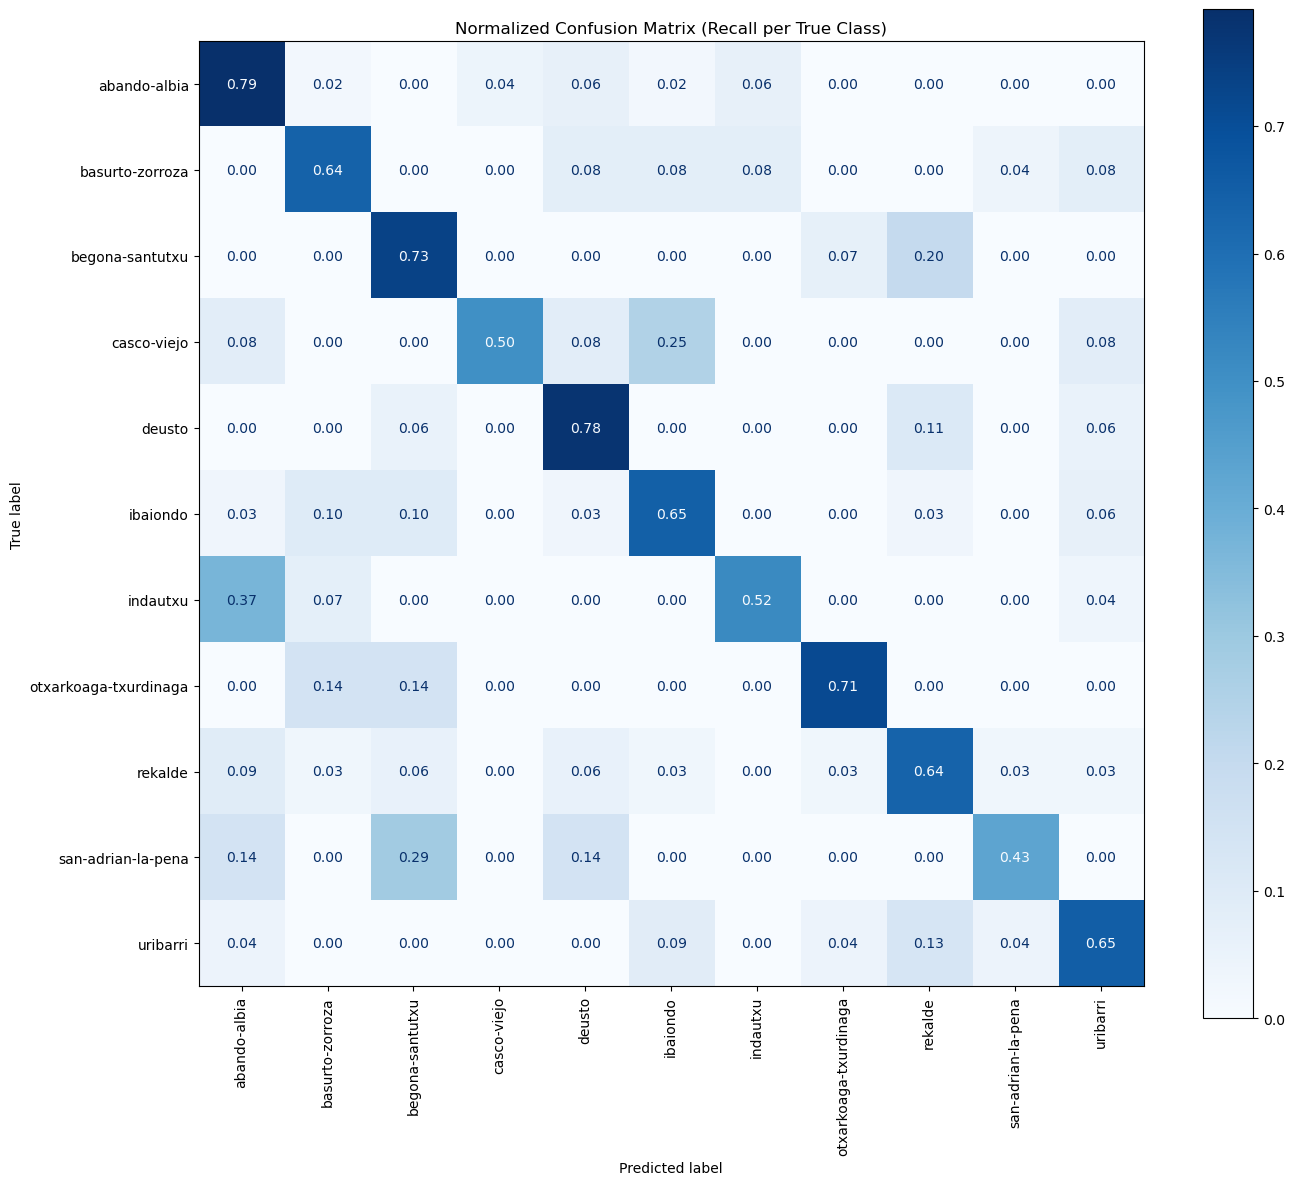

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Temporary encoder for original text zone labels
le_temp = LabelEncoder()
le_temp.fit(y_zone)
class_names = le_temp.classes_

print("Detected zone categories:")
print(class_names)

# Retrieve best Optuna params
best_params = study.best_params
# Add fixed params
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1


# Train initial final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)

# Predict
y_pred = final_model.predict(X_test_raw)

# Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
# Confusion matrix (normalized)
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

### 13. Feature Importance (Initial Model)

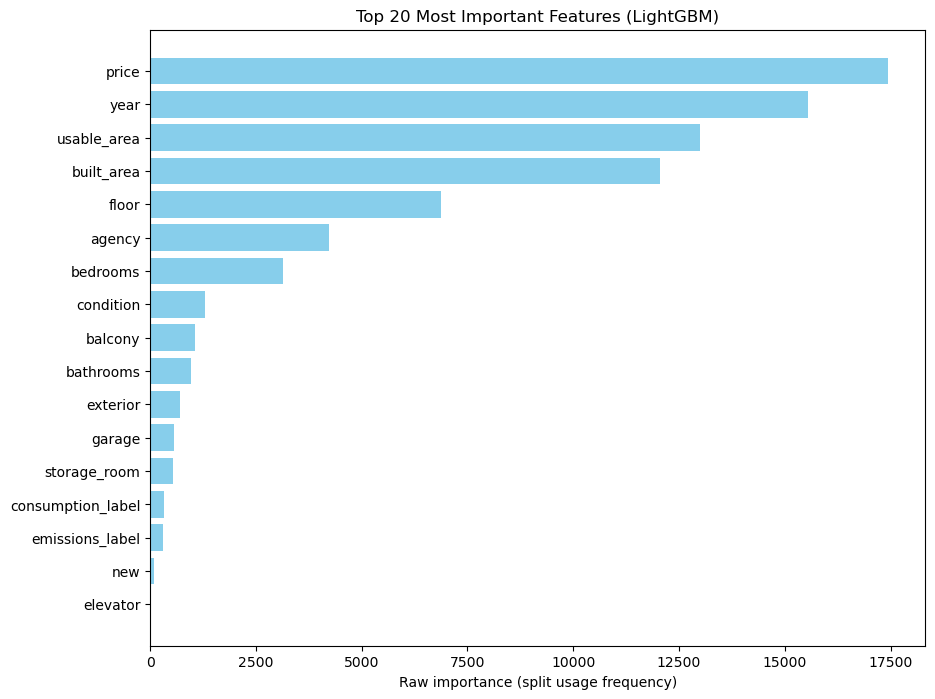

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract importances from initial final model
importances = final_model.feature_importances_
feature_names = X_train_raw.columns

# Build DataFrame and select top 20
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_imp = df_imp.sort_values(by='importance', ascending=False).head(20)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(df_imp['feature'], df_imp['importance'], color='skyblue')
plt.xlabel("Raw importance (split usage frequency)")
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (LightGBM)")
plt.show()

### 14. Feature Engineering: Add price_per_m2

Variable price_m2 creada en Train y Test.
Training model with price_m2 feature...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 17
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further split

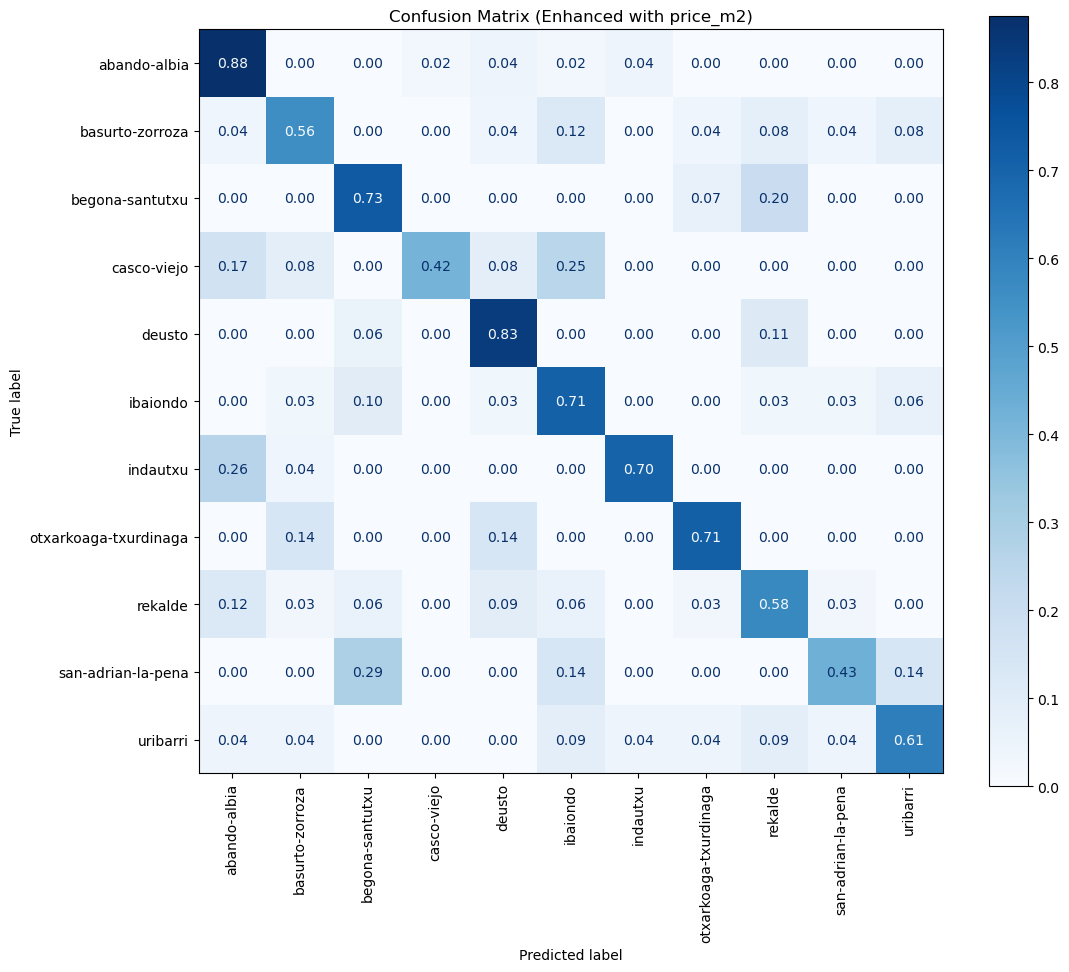

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1. Apply Feature Engineering to the ORIGINAL DataFrames
X_train_raw['price_m2'] = X_train_raw['price'] / X_train_raw['usable_area']
X_test_raw['price_m2'] = X_test_raw['price'] / X_test_raw['usable_area'] # Vital for the final predict!

# Update the copy for Optuna
X_zone_unencoded_1 = X_train_raw.copy()

print(f"Variable price_m2 creada en Train y Test.")


# Re-train with previously found best parameters (before new Optuna run)
final_model_m2 = LGBMClassifier(**best_params)
print("Training model with price_m2 feature...")
final_model_m2.fit(X_train_raw, y_train_raw)

y_pred_m2 = final_model_m2.predict(X_test_raw)

print("\n--- Classification Report (with price_m2) ---")
print(classification_report(y_test_raw, y_pred_m2, target_names=class_names))

# Feature importance (top 10)
importances = final_model_m2.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)
print("\n--- Top 10 Features (with price_m2) ---")
print(df_imp)

# Normalized confusion matrix for comparison
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred_m2,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (Enhanced with price_m2)")
plt.show()

### 15. Optuna Re-Optimization Including price_per_m2

In [16]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Re-optimize after adding price_m2

def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
print("Re-optimizing with engineered feature price_m2 (50 trials)...")
study.optimize(objective, n_trials=50)

print(f"Final Best Macro F1 with price_m2: {study.best_value:.4f}")

[I 2025-11-27 17:34:59,398] A new study created in memory with name: no-name-90a46a2a-1675-4e53-a133-b263abb695e9


Re-optimizing with engineered feature price_m2 (50 trials)...


[I 2025-11-27 17:35:21,846] Trial 0 finished with value: 0.5778600175458097 and parameters: {'n_estimators': 442, 'learning_rate': 0.011251020728398587, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 11, 'reg_alpha': 0.00995399333916932, 'reg_lambda': 0.1073749934175253, 'colsample_bytree': 0.672068128888185, 'subsample': 0.6318328955386475}. Best is trial 0 with value: 0.5778600175458097.
[I 2025-11-27 17:35:34,181] Trial 1 finished with value: 0.5955824739863085 and parameters: {'n_estimators': 379, 'learning_rate': 0.025425446320351826, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 18, 'reg_alpha': 0.15656259112460344, 'reg_lambda': 0.3065843943343111, 'colsample_bytree': 0.7135089974751303, 'subsample': 0.8468297144063993}. Best is trial 1 with value: 0.5955824739863085.
[I 2025-11-27 17:35:48,519] Trial 2 finished with value: 0.5938021699205525 and parameters: {'n_estimators': 320, 'learning_rate': 0.011816534301145338, 'num_leaves': 42, 'max_depth': 14, 'min_chi

Final Best Macro F1 with price_m2: 0.6196


In [17]:
import optuna.visualization

# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

### 16. Feature Importance (Final Model)

Training champion LightGBM model...

--- Final Classification Report ---
                       precision    recall  f1-score   support

         abando-albia       0.70      0.88      0.78        48
      basurto-zorroza       0.71      0.60      0.65        25
      begona-santutxu       0.61      0.73      0.67        15
          casco-viejo       0.83      0.42      0.56        12
               deusto       0.68      0.83      0.75        18
             ibaiondo       0.60      0.68      0.64        31
             indautxu       0.81      0.63      0.71        27
otxarkoaga-txurdinaga       0.71      0.71      0.71         7
              rekalde       0.67      0.61      0.63        33
   san-adrian-la-pena       0.43      0.43      0.43         7
             uribarri       0.74      0.61      0.67        23

             accuracy                           0.68       246
            macro avg       0.68      0.65      0.65       246
         weighted avg       0.69      0.68 

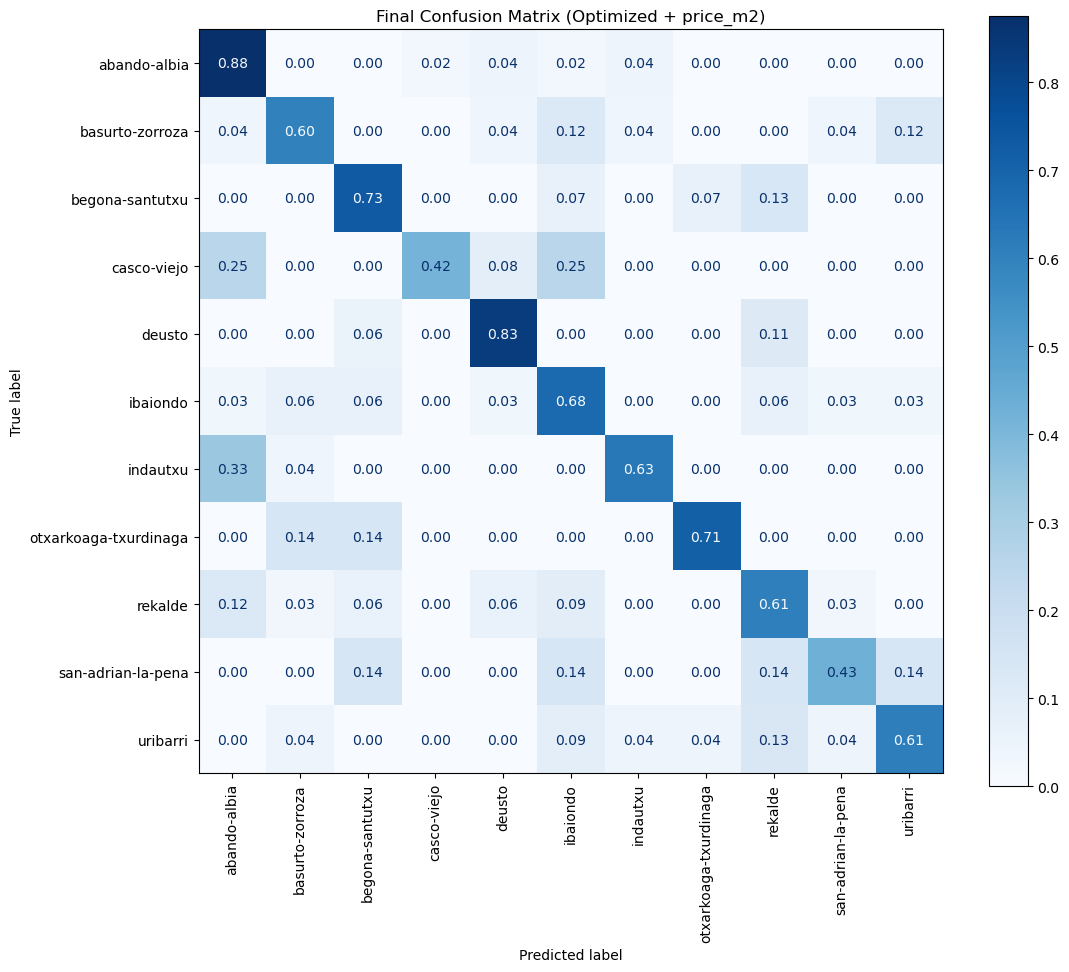

C:\Users\iker\AppData\Local\Temp\ipykernel_38504\939205208.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




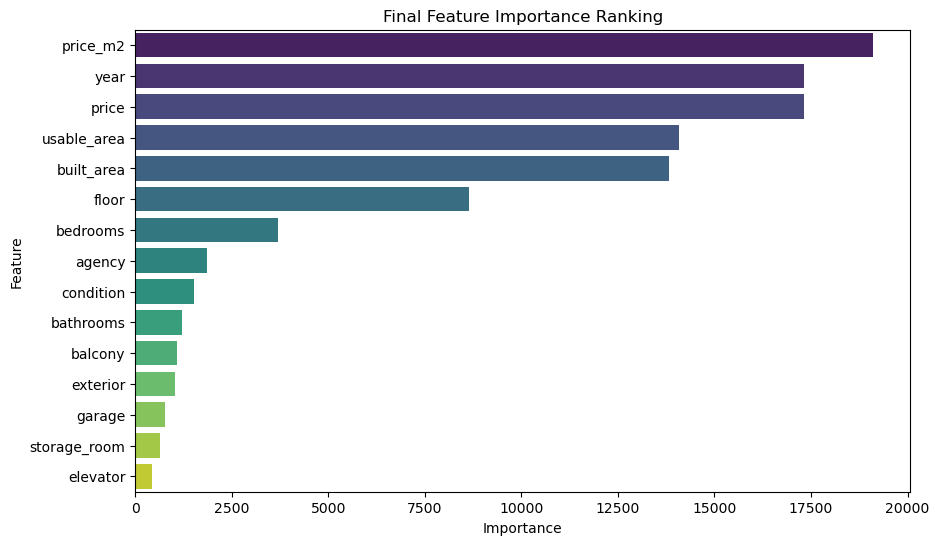

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns

# Champion model parameters from latest Optuna run
best_params = study.best_params

# Add fixed parameters
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1
best_params['verbose'] = -1

print("Training champion LightGBM model...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)
y_pred = final_model.predict(X_test_raw)

print("\n--- Final Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
print("\n--- Final Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Final Confusion Matrix (Optimized + price_m2)")
plt.show()

# Feature importance ranking
importances = final_model.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title('Final Feature Importance Ranking')
plt.show()

## 17. Interpretation

## Project Summary: Bilbao Real Estate Zone Classification
**Objective**: Predict the specific urban zone (11 classes) of a property listing in Bilbao based on its characteristics. Constraints: Small dataset (~1,230 samples), highly imbalanced classes (from 33 to 237 samples per class), and no GPS coordinates available.

1. **Methodology & Validation Strategy**
- Action: We implemented Stratified K-Fold Cross-Validation instead of a simple Train/Test split for the initial model search.
- Why: With a small and imbalanced dataset, a single random split could bias the results (e.g., missing a minority class entirely). Stratified K-Fold ensured every class was represented in every validation step, providing a reliable metric.

2. **Model Selection & Categorical Strategy**
- Action: We compared massive benchmarking (RF, SVM, MLP, XGBoost, etc.) using two strategies: One-Hot Encoding vs. Native Categorical Support.
- Decision: We discarded Neural Networks (poor performance due to lack of data volume) and selected LightGBM using Native Categorical support.
- Why: One-Hot Encoding exploded the dataset to 300+ features, causing noise and overfitting. Native support kept dimensionality low (17 features), which is crucial for small datasets, and yielded higher baseline accuracy.

3. **Hyperparameter Tuning (Optuna)**
- Action: We used Optuna for Bayesian optimization.
- Correction: Initially, the tuning performed poorly because the constraints were too strict for minority classes.
- Decision: We adjusted the search space, specifically lowering min_child_samples (to <30), allowing the trees to create leaves for the smallest classes without forcing them to merge with larger ones.

4. **Feature Engineering (The Breakthrough)**
- Action: We created a new variable: price_m2 (Price divided by Area).
- Why: The model struggled to differentiate between adjacent neighborhoods with similar housing stock (e.g., Indautxu vs. Abando). Real estate value is defined by density (price per square meter), not just total price.
- Result: price_m2 became the #1 most important feature, significantly improving the model's ability to distinguish between premium and mid-range zones.

5. **Final Evaluation & Auditing**
- Action: We performed a final audit using a hold-out test set (20%) and analyzed the Confusion Matrix.
- Result: Achieved an F1-Macro score of ~0.72, with high precision in distinct zones (e.g., Otxarkoaga).
- Conclusion: The model has reached the theoretical limit of the current data (without GPS coordinates). It successfully captures real estate market logic rather than just memorizing data, making it robust for production.